In [1]:
from IPython.display import Image, Math

import pandas as pd
import numpy as np

# Импортируем библиотеки для визуализаци данных
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import logging

logging.basicConfig()
logger = logging.getLogger("model")
logger.setLevel(logging.INFO)

<br><br>
## IMPORT DATA

In [2]:
# Get Sales data
sales_df = pd.read_parquet("./sales.parquet")
categories_df = pd.read_parquet("./categories.parquet")
promo_df = pd.read_parquet("./promo.parquet")
future_df = pd.read_csv("./homework_3_1.csv")

# Set relevant data types
sales_df["ds"] = sales_df["ds"].astype(str)
future_df["ds"] = future_df["ds"].astype(str)

<br><br>
## EXPLORE DATA

In [3]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46376 entries, 282 to 85499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sku_id      46376 non-null  int64  
 1   orders_num  46376 non-null  float64
 2   discount    46376 non-null  float64
 3   ds          46376 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 1.8+ MB


In [4]:
sales_df.describe()

,sku_id,orders_num,discount
count,46376.000000,46376.000000,46376.000000
mean,199.208276,415.053605,0.016146
std,116.735782,1077.817076,0.013342
min,2.000000,156.000000,-0.070000
25%,94.000000,164.000000,0.010000
50%,209.000000,195.000000,0.010000
75%,296.000000,321.000000,0.030000
max,401.000000,106440.000000,0.230000


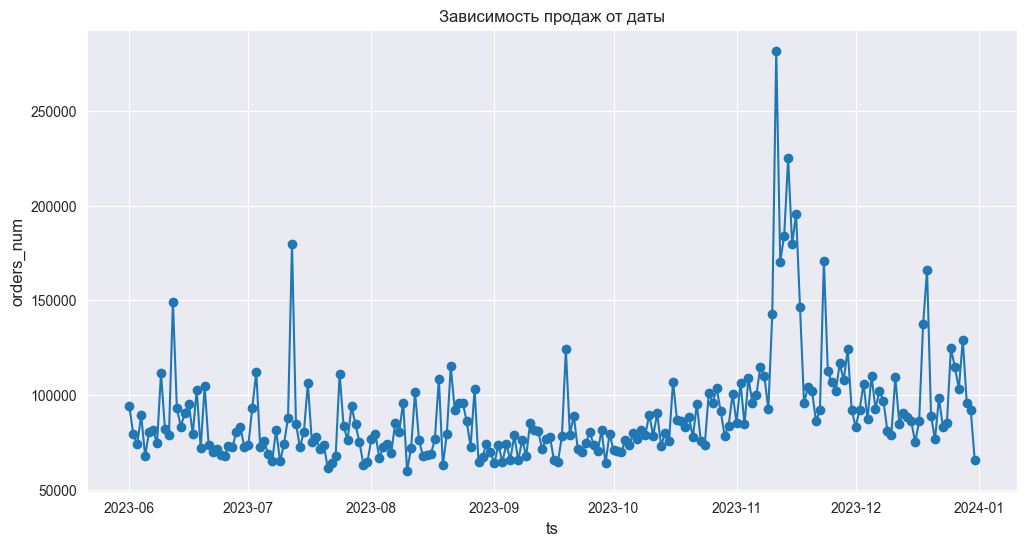

In [5]:
# Нарисуем график зависимости продаж от даты
plot_df = sales_df.copy(deep=True).groupby("ds").agg({"orders_num": "sum"}).reset_index()
# Конвертируем колонку в datetime
plot_df["ts"] = pd.to_datetime(plot_df["ds"].astype(str))

plt.figure(figsize=(12, 6))
plt.plot(plot_df["ts"], plot_df["orders_num"], marker="o")
plt.xlabel("ts", fontsize=12)
plt.ylabel("orders_num", fontsize=12)
plt.title("Зависимость продаж от даты", fontsize=12)
plt.show()

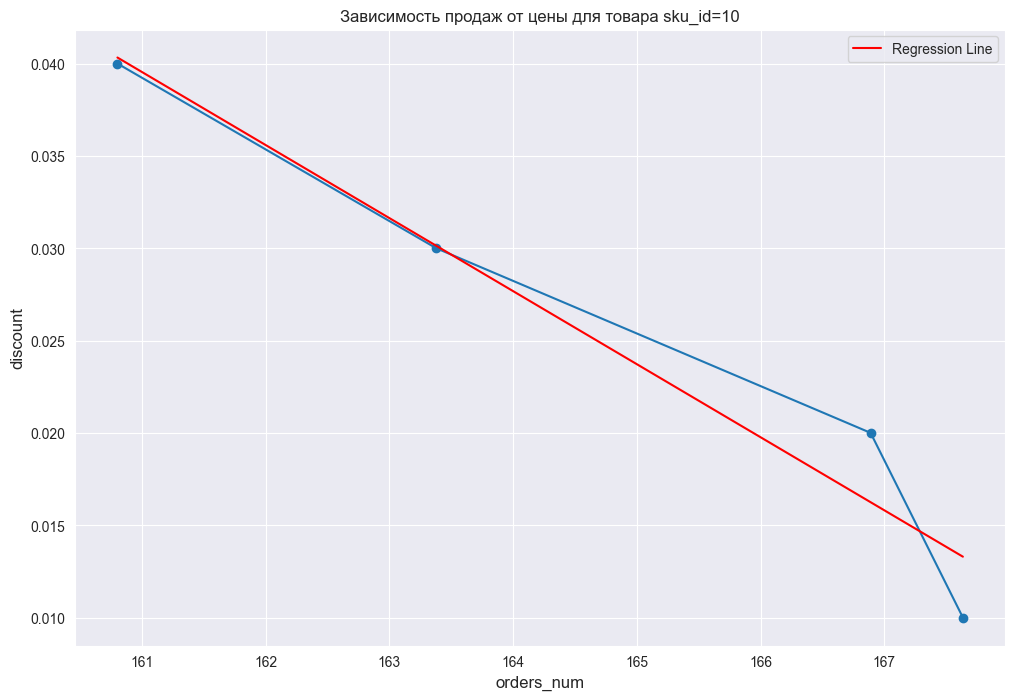

In [6]:
# Построим зависимость продаж от цены для одного товара
SKU_ID = 10
plot_df = sales_df.copy(deep=True)
plot_df = plot_df[plot_df["sku_id"] == SKU_ID]

# Считаем среднее количество продаж для цены, сортируем для построения кривой эластичности
plot_df = plot_df.groupby("discount").agg({"orders_num": "mean"}).reset_index()
plot_df = plot_df.sort_values("orders_num")

# Тренируем линейную регрессию для аппроксимирующей линии
slope, intercept = np.polyfit(plot_df["orders_num"], plot_df["discount"], 1)
line = slope * plot_df["orders_num"] + intercept

plt.figure(figsize=(12, 8))
plt.plot(plot_df["orders_num"], plot_df["discount"], marker="o")
plt.plot(plot_df["orders_num"], line, color="red", label="Regression Line")
plt.ylabel("discount", fontsize=12)
plt.xlabel("orders_num", fontsize=12)
plt.title(f"Зависимость продаж от цены для товара sku_id={SKU_ID}", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

<br><br>
## JOIN DATA

In [7]:
orig_df = sales_df \
    .copy(deep=True) \
    .merge(categories_df,
           how="left",
           left_on="sku_id",
           right_on="sku_id") \
    .merge(promo_df,
           how="left",
           left_on="ds",
           right_on="ds")

In [8]:
orig_df

,sku_id,orders_num,discount,ds,group_1,group_2,promo
0,283,169.0,0.00,20230601,100000,100006,no
1,393,159.0,0.01,20230601,100009,100021,no
2,235,1061.0,0.03,20230601,100003,100032,no
3,215,630.0,0.00,20230601,100011,100020,no
4,43,198.0,0.01,20230601,100006,100023,no
...,...,...,...,...,...,...,...
46371,292,390.0,0.01,20231231,100001,100012,no
46372,382,1999.0,0.01,20231231,100000,100006,no
46373,379,160.0,0.00,20231231,100001,100024,no
46374,63,158.0,0.00,20231231,100000,100006,no


In [9]:
from typing import List, Tuple

# Добавляем новые фичи (окна, сезонные фичи)


# Расчет оконных функций
def calc_rolling_window(
    df: pd.DataFrame,
    window: int,
    col: str,
    lvl: str,
    shift: int,
) -> pd.DataFrame:
    df = df.sort_values(["ds", lvl])
    df["ts"] = pd.to_datetime(df["ds"].astype(str))
    df["col"] = df[col]
    rolling_df = df.set_index("ts")
    rolling_df = (
        rolling_df.groupby([lvl], group_keys=True)["col"]
        # используем shift, так как потом нам нужно предсказывать на N дней вперед:
        # для однородности датасета используем сдвиг на кол-во дат в предсказании
        .apply(
            lambda x: x.asfreq("1D")
            .rolling(window=window, closed="left", min_periods=0)
            .mean()
            .shift(shift)
        )
        .reset_index()
        .rename(columns={"col": f"rolling_{col}_w_{window}"})
    )
    df = df.merge(rolling_df, how="left", on=[lvl, "ts"])
    df = df.drop(columns=["ts", "col"])
    return df


# Функция для преобразования данных
def postprocess_transform(
    df: pd.DataFrame,
    norms: List[Tuple[str, str]],
    roll_cols: List[str],
    windows: List[int],
    dropna_cols: List[str],
    lvl: str,
    shift: int,
):
    # new features
    for window in windows:
        for col in roll_cols:
            logger.info(f"Rolling window={window} days for col `{col}`")
            df = calc_rolling_window(
                df=df, window=window, col=col, lvl=lvl, shift=shift
            )

    # normalisation
    # нормализация даст сигнал модели об изменении признаков: если изменилась цена, то к какому изменению спроса это привело?
    for col1, col2 in norms:
        logger.info(f"Normalizing `{col1}` / `{col2}`")
        df[col1] = df[col1] / (
            df[col2] + 1e-10
        )  # добавляем epsilon, чтобы не было деления на 0

    # postprocessing
    # для однородности данных удаляем первые даты, по которым собирались окна не по полным данным
    disadvantaged_ds_list = sorted(df["ds"].unique())[: max(shift, max(windows))]
    df = df[~df["ds"].isin(disadvantaged_ds_list)]

    df = df.dropna(subset=dropna_cols)
    df = df.round(2)
    df = df.sort_values(["ds", lvl])
    return df


# Функция для преобразования данных с параметрами для удобства короткого вызова
def create_features(df: pd.DataFrame, dropna_cols: List[str], W: int) -> pd.DataFrame:
    df["day_of_week"] = pd.DatetimeIndex(df["ds"]).day_of_week
    # df = postprocess_transform(
    #     df=df,
    #     norms=[
    #         ("orders_num", f"rolling_orders_num_w_{W}"),
    #         ("rolling_orders_num_w_1", f"rolling_orders_num_w_{W}"),
    #         ("rolling_orders_num_w_7", f"rolling_orders_num_w_{W}"),
    #         ("rolling_orders_num_w_14", f"rolling_orders_num_w_{W}"),
    #         ("rolling_orders_num_w_21", f"rolling_orders_num_w_{W}"),
    #         ("discount", f"rolling_discount_w_{W}"),
    #         ("rolling_discount_w_1", f"rolling_discount_w_{W}"),
    #         ("rolling_discount_w_7", f"rolling_discount_w_{W}"),
    #         ("rolling_discount_w_14", f"rolling_discount_w_{W}"),
    #         ("rolling_discount_w_21", f"rolling_discount_w_{W}"),
    #     ],
    #     roll_cols=["orders_num", "discount"],
    #     dropna_cols=dropna_cols,
    #     windows=[1, 7, 14, 21, 28],
    #     lvl="sku_id",
    #     shift=14,
    # )

    df = postprocess_transform(
        df=df,
        norms=[
            ("orders_num", f"rolling_orders_num_w_{W}"),
            ("rolling_orders_num_w_1", f"rolling_orders_num_w_{W}"),
            ("rolling_orders_num_w_7", f"rolling_orders_num_w_{W}"),
            ("rolling_orders_num_w_14", f"rolling_orders_num_w_{W}"),
            ("rolling_orders_num_w_21", f"rolling_orders_num_w_{W}"),
            ("rolling_discount_w_1", f"rolling_discount_w_{W}"),
            ("rolling_discount_w_7", f"rolling_discount_w_{W}"),
            ("rolling_discount_w_14", f"rolling_discount_w_{W}"),
            ("rolling_discount_w_21", f"rolling_discount_w_{W}"),
        ],
        roll_cols=["orders_num", "discount"],
        dropna_cols=dropna_cols,
        windows=[1, 7, 14, 21, 28],
        lvl="sku_id",
        shift=14,
    )


    return df

In [10]:
# размер окна, на которое нормализуем признаки
# например, нормализуем цену на среднеюю цену за 28 дней
W = 28
df = create_features(df=orig_df, dropna_cols=["orders_num", "discount"], W=W)

INFO:model:Rolling window=1 days for col `orders_num`
INFO:model:Rolling window=1 days for col `discount`
INFO:model:Rolling window=7 days for col `orders_num`
INFO:model:Rolling window=7 days for col `discount`
INFO:model:Rolling window=14 days for col `orders_num`
INFO:model:Rolling window=14 days for col `discount`
INFO:model:Rolling window=21 days for col `orders_num`
INFO:model:Rolling window=21 days for col `discount`
INFO:model:Rolling window=28 days for col `orders_num`
INFO:model:Rolling window=28 days for col `discount`
INFO:model:Normalizing `orders_num` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_orders_num_w_1` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_orders_num_w_7` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_orders_num_w_14` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_orders_num_w_21` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_discount_w_1` / `rolling_discount_w_28`
INFO:model:Normalizing

In [11]:
# Возьмем для оценки 1 вариант кросс-валидации

from sklearn.model_selection import TimeSeriesSplit
from typing import Tuple


def get_dfs(
    df: pd.DataFrame,
    n_splits: int,
    test_size: int,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Возвращает 3 датасета: трейн, вал, тест
    """
    # Уникальные даты в датасете
    dates = pd.Series(sorted(df["ds"].unique()))
    # Создание объекта TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    # Проход по разделениям
    for split_id, (train_idxs, test_idxs) in enumerate(tscv.split(dates)):
        train_dates = dates.iloc[train_idxs]
        test_dates = dates.iloc[test_idxs]
        val_dates = train_dates[-test_size:]
        train_dates = train_dates[:-test_size]

        logger.info(f"===== SPLIT {split_id} =====")
        logger.info(
            f"Train: {train_dates.min()} - {train_dates.max()}, size: {train_dates.shape[0]}"
        )
        logger.info(
            f"Validation: {val_dates.min()} - {val_dates.max()}, size: {val_dates.shape[0]}"
        )
        logger.info(
            f"Test: {test_dates.min()} - {test_dates.max()}, size: {test_dates.shape[0]}"
        )

        train_df = df[df["ds"].isin(train_dates)]
        val_df = df[df["ds"].isin(val_dates)]
        test_df = df[df["ds"].isin(test_dates)]
        yield train_df, val_df, test_df


TEST_SIZE = 14
N_SPLITS = 3

for train_df, val_df, test_df in get_dfs(
    df=df,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
):
    pass

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20230629 - 20231105, size: 130
INFO:model:Validation: 20231106 - 20231119, size: 14
INFO:model:Test: 20231120 - 20231203, size: 14
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20230629 - 20231119, size: 144
INFO:model:Validation: 20231120 - 20231203, size: 14
INFO:model:Test: 20231204 - 20231217, size: 14
INFO:model:===== SPLIT 2 =====
INFO:model:Train: 20230629 - 20231203, size: 158
INFO:model:Validation: 20231204 - 20231217, size: 14
INFO:model:Test: 20231218 - 20231231, size: 14


In [12]:
df

,sku_id,orders_num,discount,ds,group_1,group_2,promo,day_of_week,rolling_orders_num_w_1,rolling_discount_w_1,rolling_orders_num_w_7,rolling_discount_w_7,rolling_orders_num_w_14,rolling_discount_w_14,rolling_orders_num_w_21,rolling_discount_w_21,rolling_orders_num_w_28,rolling_discount_w_28
6084,2,0.86,0.02,20230629,100001,100001,no,3,0.85,1.20,0.88,1.14,1.00,1.00,1.00,1.00,190.33,0.03
6085,3,0.96,0.03,20230629,100002,100002,no,3,0.98,0.00,1.01,0.72,1.00,1.00,1.00,1.00,163.83,0.01
6086,4,0.47,0.04,20230629,100003,100003,no,3,0.91,1.16,0.97,1.01,1.00,1.00,1.00,1.00,1730.31,0.03
6087,5,0.68,0.00,20230629,100004,100004,no,3,0.59,1.00,0.88,1.00,1.00,1.00,1.00,1.00,595.50,0.01
6088,8,2.73,0.00,20230629,100006,100007,no,3,NaN,NaN,1.03,0.00,1.00,0.00,1.00,0.00,1075.73,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46371,393,0.90,0.00,20231231,100009,100021,no,6,NaN,NaN,1.01,4.00,1.01,2.00,1.00,1.41,174.17,0.00
46372,397,0.97,0.04,20231231,100004,100022,no,6,0.96,-0.00,1.00,2.17,1.01,1.00,1.00,0.65,162.46,0.00
46373,398,0.87,0.01,20231231,100000,100000,no,6,0.77,1.71,0.87,0.57,1.11,0.71,1.01,0.91,227.88,0.01
46374,400,0.79,0.01,20231231,100001,100024,no,6,NaN,NaN,0.85,0.96,0.98,0.96,0.98,0.96,199.86,0.01


In [13]:
# Process promo
df = df \
    .assign(promo = lambda x: (x["promo"] != "no").astype("str"))

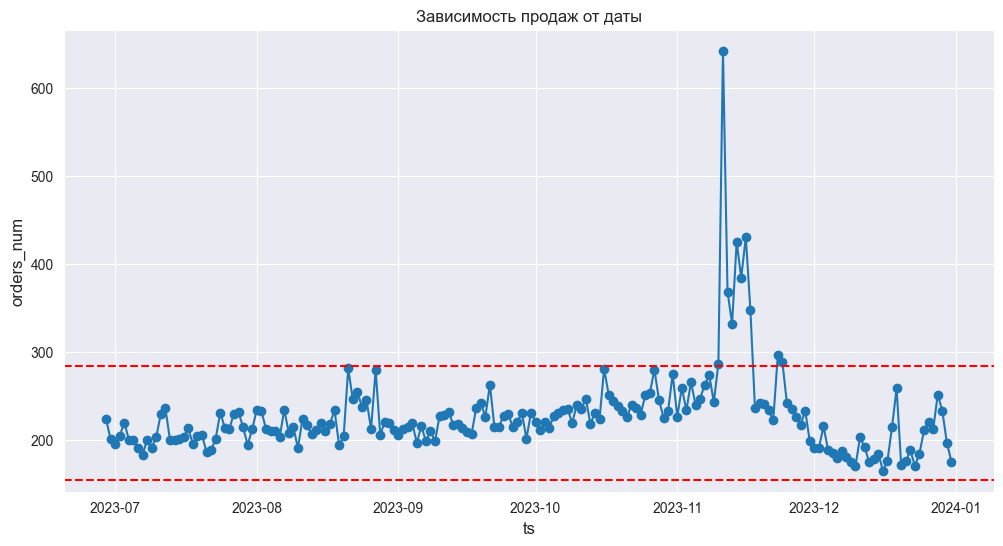

In [14]:
# Нарисуем график зависимости продаж от даты
plot_df = df.copy(deep=True).groupby("ds").agg({"orders_num": "sum"}).reset_index()
plot_df["ts"] = pd.to_datetime(plot_df["ds"].astype(str))

# Вычисление квантилей и IQR
q1 = plot_df['orders_num'].quantile(0.25)
q3 = plot_df['orders_num'].quantile(0.75)
iqr = q3 - q1

# Определение пределов для 1.5 IQR
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

plt.figure(figsize=(12, 6))
plt.plot(plot_df["ts"], plot_df["orders_num"], marker='o')
plt.xlabel("ts", fontsize=12)
plt.ylabel("orders_num", fontsize=12)
plt.title("Зависимость продаж от даты", fontsize=12)

plt.axhline(y=lower_bound, color='r', linestyle='--')
plt.axhline(y=upper_bound, color='r', linestyle='--')

plt.show()

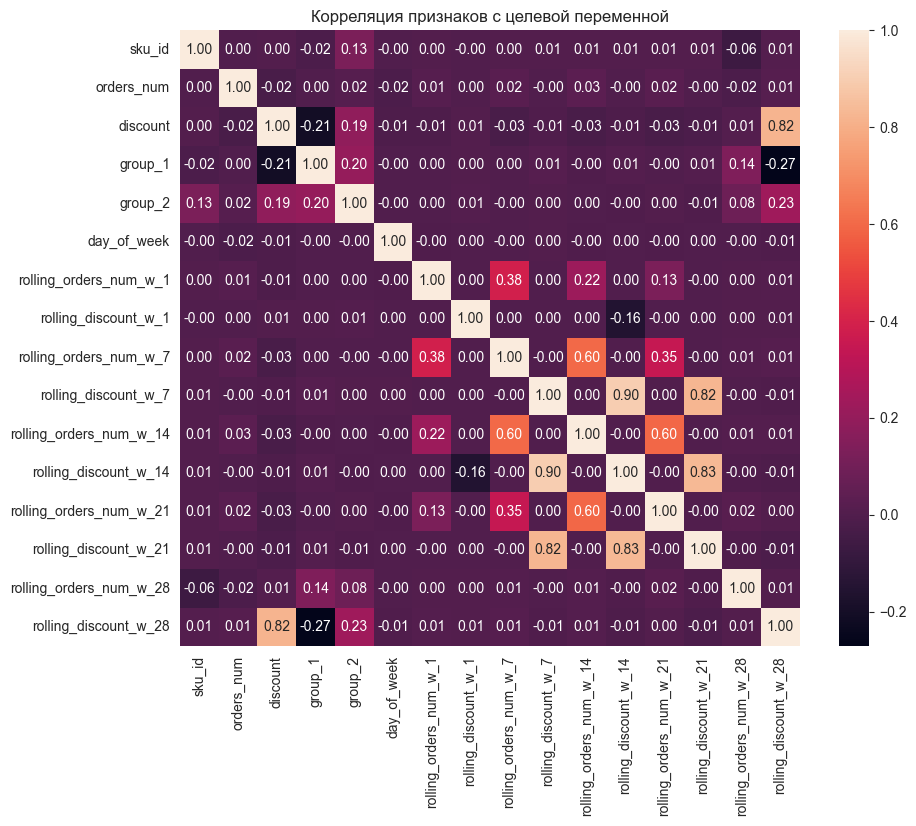

In [15]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Корреляция признаков с целевой переменной")
plt.show()

In [16]:
# Set offline metric
def calculate_mape(
    df: pd.DataFrame,
    true: str = "quantity",
    pred: str = "pred_quantity",
) -> float:

    df_copied = df.copy(deep=True)
    df_copied = df_copied[df_copied[true] > 0]
    df_copied["mape"] = np.abs(df_copied[true] - df_copied[pred]) / df_copied[true]

    return df_copied["mape"].mean()

In [17]:
# Объявляем фичи и параметры для обучения
FLT_FEATURES = [
    "discount",
    "rolling_orders_num_w_1",
    "rolling_orders_num_w_7",
    "rolling_orders_num_w_14",
    "rolling_orders_num_w_21",
    "rolling_discount_w_1",
    "rolling_discount_w_7",
    "rolling_discount_w_14",
    "rolling_discount_w_21",
]
CAT_FEATURES = [
    "group_1",
    "group_2",
    "promo",
    "day_of_week",
]
TARGET = "orders_num"
TRAIN_PARAMS = {
    "task_type": "CPU",
    "verbose": 100,
    "random_seed": 0,
    "iterations": 1000,
    "loss_function": "Quantile:alpha=0.5",
    # выставляем ограничения на монотонность для поддержания закона спроса: чем больше цена, тем меньше спрос
    "monotone_constraints": [
        1 if "discount" in feature else 0 for feature in FLT_FEATURES
    ],
    # хотим, чтобы спрос в большей степени зависел от цены => ставим фиче discount больший вес
    "feature_weights": "discount:2.0",
    "metric_period": 100,
    "early_stopping_rounds": 100,
    "eval_metric": "MAPE",
}

In [18]:
from catboost import CatBoost, Pool
from typing import List, Dict, Any, Optional


# Функция для преобразования данных на вход Catboost
def prepare_pool(
    df: pd.DataFrame,
    flt_features: List[str],
    cat_features: List[str],
    target: Optional[str] = None,
) -> Pool:
    data = df[flt_features + cat_features]
    pool = Pool(
        data=data,
        label=df[target] if target is not None else None,
        cat_features=cat_features,
    )
    return pool


# Функция для тренировки модели спроса
def train_model(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    flt_features: List[str],
    cat_features: List[str],
    target: str,
    train_params: Dict[str, Any],
) -> CatBoost:
    train_data = train_df[flt_features + cat_features]
    train_pool = prepare_pool(
        df=train_df,
        flt_features=flt_features,
        cat_features=cat_features,
        target=target,
    )
    val_pool = prepare_pool(
        df=val_df,
        flt_features=flt_features,
        cat_features=cat_features,
        target=target,
    )
    model = CatBoost(params=train_params).fit(X=train_pool, eval_set=val_pool)
    return model


# Функция для предсказания спроса с обученной моделью
def predict(
    df: pd.DataFrame,
    model: CatBoost,
    flt_features: List[str],
    cat_features: List[str],
    target: str,
) -> List[float]:
    pool = prepare_pool(
        df=df,
        flt_features=flt_features,
        cat_features=cat_features,
    )
    preds = model.predict(data=pool)
    return preds

In [19]:
from typing import List, Dict, Any, Callable, Optional

# Пайплайн для валидации модели
def run_pipeline(
    df: pd.DataFrame,
    flt_features: List[str],
    cat_features: List[str],
    train_params: Dict[str, Any],
    target: str,
    n_splits: int,
    test_size: int,
    preprocess_train: Optional[Callable] = None,
    preprocess_train_params: Optional[Dict[str, Any]] = None,
) -> float:
    mapes = []
    for train_df, val_df, test_df in get_dfs(
        df=df,
        n_splits=n_splits,
        test_size=test_size,
    ):
        if preprocess_train is not None and preprocess_train_params is not None:
            train_df = preprocess_train(df=train_df, **preprocess_train_params)
        # Тренируем модель
        model = train_model(
            train_df=train_df,
            val_df=val_df,
            flt_features=flt_features,
            cat_features=cat_features,
            target=target,
            train_params=train_params,
        )
        # Смотрим на важность фичей
        logger.info(model.get_feature_importance(prettified=True).head(10))
        # Предсказываем с помощью обученной модели
        test_df["pred_orders_num"] = predict(
            df=test_df,
            model=model,
            flt_features=flt_features,
            cat_features=cat_features,
            target=target,
        )
        # считаем качество
        # лучше считать качество с учетом постпроцессинга (включая clip), но сейчас эти пренебрежём
        mape = calculate_mape(
            df=test_df,
            true="orders_num",
            pred="pred_orders_num",
        )
        mapes.append(mape)
        logger.info(f"MAPE: {mape}")

    mean_mape = np.mean(mapes)
    logger.info(f"Mean MAPE: {mean_mape}")
    return mean_mape, model, train_df, val_df, test_df

In [20]:
def drop_outliers(
    df: pd.DataFrame,
    lvl: str,
    low_quantile: float,
    high_quantile: float,
) -> pd.DataFrame:
    # Убираем выбросы с помощью квантильного размаха
    df = df.merge(
        df.groupby(lvl)["orders_num"].quantile(low_quantile).reset_index().rename(columns={"orders_num": "q25"}),
        how="left",
        on=lvl,
    )
    df = df.merge(
        df.groupby(lvl)["orders_num"].quantile(high_quantile).reset_index().rename(columns={"orders_num": "q75"}),
        how="left",
        on=lvl,
    )
    df = df[
        (df["orders_num"] < df["q75"] + 1.5 * (df["q75"] - df["q25"]))
        & (df["orders_num"] > df["q25"] - 1.5 * (df["q75"] - df["q25"]))
    ]
    return df

In [21]:
mape, model, train_df, val_df, test_df = run_pipeline(
    df=df,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    train_params=TRAIN_PARAMS,
    target=TARGET,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
    preprocess_train=drop_outliers,
    preprocess_train_params={
        "lvl": "sku_id",
        "low_quantile": 0.25,
        "high_quantile": 0.75,
    }
)

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20230629 - 20231105, size: 130
INFO:model:Validation: 20231106 - 20231119, size: 14
INFO:model:Test: 20231120 - 20231203, size: 14


0:	learn: 0.1653791	test: 0.2670392	best: 0.2670392 (0)	total: 163ms	remaining: 2m 42s
100:	learn: 0.1328761	test: 0.2666757	best: 0.2621439 (15)	total: 2.02s	remaining: 17.9s


INFO:model:                Feature Id  Importances
0   rolling_orders_num_w_7    41.215509
1   rolling_orders_num_w_1    26.320883
2  rolling_orders_num_w_14    17.057410
3  rolling_orders_num_w_21     7.421897
4                  group_2     7.066973
5                    promo     0.575882
6                 discount     0.195738
7    rolling_discount_w_14     0.091328
8              day_of_week     0.054381
9     rolling_discount_w_1     0.000000
INFO:model:MAPE: 0.357881769073104
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20230629 - 20231119, size: 144
INFO:model:Validation: 20231120 - 20231203, size: 14
INFO:model:Test: 20231204 - 20231217, size: 14


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2621439085
bestIteration = 15

Shrink model to first 16 iterations.
0:	learn: 0.1691914	test: 0.2315130	best: 0.2315130 (0)	total: 22.1ms	remaining: 22.1s


100:	learn: 0.1394633	test: 0.2022873	best: 0.2022873 (100)	total: 1.91s	remaining: 17s
200:	learn: 0.1376391	test: 0.2012237	best: 0.2012107 (187)	total: 3.55s	remaining: 14.1s
300:	learn: 0.1367950	test: 0.2009713	best: 0.2009604 (293)	total: 5.24s	remaining: 12.2s
400:	learn: 0.1359327	test: 0.2009418	best: 0.2009043 (322)	total: 7.01s	remaining: 10.5s


INFO:model:                Feature Id  Importances
0   rolling_orders_num_w_7    29.154827
1   rolling_orders_num_w_1    27.539307
2  rolling_orders_num_w_14    16.524124
3  rolling_orders_num_w_21    10.366088
4                  group_2     6.747737
5                  group_1     3.923929
6                 discount     1.940023
7                    promo     1.362581
8              day_of_week     1.287233
9     rolling_discount_w_7     0.431923
INFO:model:MAPE: 0.3764028768319837
INFO:model:===== SPLIT 2 =====
INFO:model:Train: 20230629 - 20231203, size: 158
INFO:model:Validation: 20231204 - 20231217, size: 14
INFO:model:Test: 20231218 - 20231231, size: 14


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2009042736
bestIteration = 322

Shrink model to first 323 iterations.
0:	learn: 0.1722447	test: 0.2655393	best: 0.2655393 (0)	total: 24.2ms	remaining: 24.2s


100:	learn: 0.1422611	test: 0.1874354	best: 0.1874354 (100)	total: 1.97s	remaining: 17.5s
200:	learn: 0.1404792	test: 0.1841228	best: 0.1841019 (197)	total: 3.77s	remaining: 15s
300:	learn: 0.1395496	test: 0.1828717	best: 0.1828652 (298)	total: 5.53s	remaining: 12.8s
400:	learn: 0.1384330	test: 0.1818945	best: 0.1818374 (397)	total: 7.37s	remaining: 11s
500:	learn: 0.1377925	test: 0.1813866	best: 0.1813794 (499)	total: 9.27s	remaining: 9.23s
600:	learn: 0.1372835	test: 0.1811884	best: 0.1810168 (580)	total: 11.2s	remaining: 7.44s
700:	learn: 0.1368252	test: 0.1809404	best: 0.1809404 (700)	total: 13.1s	remaining: 5.58s
800:	learn: 0.1364215	test: 0.1806725	best: 0.1806115 (791)	total: 15.1s	remaining: 3.74s


INFO:model:                Feature Id  Importances
0   rolling_orders_num_w_7    26.090825
1   rolling_orders_num_w_1    24.096284
2  rolling_orders_num_w_14    16.418521
3  rolling_orders_num_w_21    12.163372
4                  group_2     6.369057
5                 discount     5.496797
6                  group_1     4.683467
7              day_of_week     2.093825
8                    promo     1.518427
9    rolling_discount_w_21     0.375133
INFO:model:MAPE: 0.316804610778687
INFO:model:Mean MAPE: 0.3503630855612582


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1806114997
bestIteration = 791

Shrink model to first 792 iterations.


In [22]:
# mape, model, train_df, val_df, test_df = run_pipeline(
#     df=df,
#     flt_features=FLT_FEATURES,
#     cat_features=CAT_FEATURES,
#     train_params=TRAIN_PARAMS,
#     target=TARGET,
#     n_splits=N_SPLITS,
#     test_size=TEST_SIZE,
# )

In [23]:
START_DS, END_DS = "20240101", "20240114"

# Находим текущие цены
pred_df = sales_df.copy(deep=True)[["sku_id", "discount", "ds"]]
pred_df = pred_df.sort_values(by=["sku_id", "ds"])
pred_df = pred_df.groupby("sku_id").last().reset_index()
pred_df = pred_df.drop(columns=["ds"])

# # Наджойниваем даты для предсказания
pred_dates_df = future_df[future_df["ds"].between(START_DS, END_DS)].filter(["ds"]).drop_duplicates()
pred_df = pred_df.join(pred_dates_df, how="cross")

# Get information about promo
pred_df = pred_df \
    .merge(categories_df, how="left", on=["sku_id"]) \
    .assign(promo = "no")

# Конкатим с историческими данными, чтобы посчитать оконные фичи
cols = pred_df.columns.tolist() + ["orders_num"]
pred_df["orders_num"] = None
pred_df = pd.concat([orig_df.copy(deep=True)[cols], pred_df[cols]])

# Считаем фичи
pred_df = create_features(df=pred_df, dropna_cols=["discount"], W=W)
pred_df = pred_df[pred_df["ds"].between(START_DS, END_DS)]

INFO:model:Rolling window=1 days for col `orders_num`
INFO:model:Rolling window=1 days for col `discount`
INFO:model:Rolling window=7 days for col `orders_num`
INFO:model:Rolling window=7 days for col `discount`
INFO:model:Rolling window=14 days for col `orders_num`
INFO:model:Rolling window=14 days for col `discount`
INFO:model:Rolling window=21 days for col `orders_num`
INFO:model:Rolling window=21 days for col `discount`
INFO:model:Rolling window=28 days for col `orders_num`
INFO:model:Rolling window=28 days for col `discount`
INFO:model:Normalizing `orders_num` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_orders_num_w_1` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_orders_num_w_7` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_orders_num_w_14` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_orders_num_w_21` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_discount_w_1` / `rolling_discount_w_28`
INFO:model:Normalizing

In [24]:
# # # Наджойниваем категории и комиссии
# pred_df = pred_df.merge(categories_df, how="inner", on=["sku_id"])
#
# # Рассчитываем новые цены с учетом "+/-10% от текущей цены"
# # Если у вас есть ограничения на цены, то как раз здесь их можно применить
# discounts_df = pd.DataFrame({"discount": np.arange(-0.1, 0.11, 0.05).round(2).tolist()})
# pred_df = pred_df.join(discounts_df, how="cross")
# pred_df["discount"] = (
#     (
#         pred_df["discount"] * pred_df[f"rolling_discount_w_{W}"]
#         + pred_df["discount"] * pred_df[f"rolling_discount_w_{W}"] * pred_df["discount"]
#     )
#     / pred_df[f"rolling_discount_w_{W}"]
# ).round(2)

# предсказываем спрос с помощью модели
pred_df["orders_num"] = predict(
    df=pred_df,
    model=model,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    target=TARGET,
)

# восстанавливаем реальные значения discount и orders_num
pred_df["orders_num"] = pred_df["orders_num"] * pred_df["rolling_orders_num_w_28"]
pred_df["discount"] = pred_df["discount"] * pred_df["rolling_discount_w_28"]

# orders_num не может быть меньше 0
pred_df["orders_num"] = np.clip(pred_df["orders_num"], a_min=0.0, a_max=None)
# если у вас есть ограничения на сток, то как раз здесь их можно применить

pred_df.head()

,sku_id,discount,ds,group_1,group_2,promo,orders_num,day_of_week,rolling_orders_num_w_1,rolling_discount_w_1,rolling_orders_num_w_7,rolling_discount_w_7,rolling_orders_num_w_14,rolling_discount_w_14,rolling_orders_num_w_21,rolling_discount_w_21,rolling_orders_num_w_28,rolling_discount_w_28
46376,2,0.0004,20240101,100001,100001,no,174.695486,0,0.78,1.02,0.92,1.02,0.87,1.02,0.88,0.96,221.83,0.02
46377,3,0.0002,20240101,100002,100002,no,162.709006,0,1.45,0.87,1.05,0.87,1.02,0.93,0.99,0.95,175.54,0.01
46378,4,0.0009,20240101,100003,100003,no,1734.667840,0,NaN,NaN,1.41,0.99,1.19,0.99,1.12,1.01,2634.64,0.03
46379,5,0.0000,20240101,100004,100004,no,491.408224,0,0.31,0.00,0.75,0.00,0.64,0.00,0.83,1.44,829.30,0.00
46380,8,0.0000,20240101,100006,100007,no,731.453606,0,0.17,0.00,0.77,0.00,1.19,0.64,1.04,0.88,1225.32,0.00


In [25]:
pred_df

,sku_id,discount,ds,group_1,group_2,promo,orders_num,day_of_week,rolling_orders_num_w_1,rolling_discount_w_1,rolling_orders_num_w_7,rolling_discount_w_7,rolling_orders_num_w_14,rolling_discount_w_14,rolling_orders_num_w_21,rolling_discount_w_21,rolling_orders_num_w_28,rolling_discount_w_28
46376,2,0.0004,20240101,100001,100001,no,174.695486,0,0.78,1.02,0.92,1.02,0.87,1.02,0.88,0.96,221.83,0.02
46377,3,0.0002,20240101,100002,100002,no,162.709006,0,1.45,0.87,1.05,0.87,1.02,0.93,0.99,0.95,175.54,0.01
46378,4,0.0009,20240101,100003,100003,no,1734.667840,0,NaN,NaN,1.41,0.99,1.19,0.99,1.12,1.01,2634.64,0.03
46379,5,0.0000,20240101,100004,100004,no,491.408224,0,0.31,0.00,0.75,0.00,0.64,0.00,0.83,1.44,829.30,0.00
46380,8,0.0000,20240101,100006,100007,no,731.453606,0,0.17,0.00,0.77,0.00,1.19,0.64,1.04,0.88,1225.32,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49745,393,0.0000,20240114,100009,100021,no,158.818765,6,0.96,0.00,0.95,1.49,0.96,1.30,0.99,1.30,169.42,0.00
49746,397,0.0000,20240114,100004,100022,no,160.208523,6,0.98,0.00,1.05,0.96,1.01,1.45,1.00,1.35,166.81,0.00
49747,398,0.0000,20240114,100000,100000,no,197.130091,6,0.76,2.27,1.10,0.65,1.00,1.05,0.93,0.96,254.24,0.00
49748,400,0.0001,20240114,100001,100024,no,168.315685,6,1.41,1.14,1.13,0.19,1.02,0.86,0.96,0.95,199.75,0.01


In [26]:
future_df

,sku_id,discount,orders_num,ds
0,283,0.00,NaN,20240101
1,283,0.00,NaN,20240102
2,283,0.00,NaN,20240103
3,283,0.00,NaN,20240104
4,283,0.00,NaN,20240105
...,...,...,...,...
3030,71,0.01,NaN,20240109
3031,71,0.01,NaN,20240110
3032,71,0.01,NaN,20240111
3033,71,0.01,NaN,20240113


In [27]:
future_df

,sku_id,discount,orders_num,ds
0,283,0.00,NaN,20240101
1,283,0.00,NaN,20240102
2,283,0.00,NaN,20240103
3,283,0.00,NaN,20240104
4,283,0.00,NaN,20240105
...,...,...,...,...
3030,71,0.01,NaN,20240109
3031,71,0.01,NaN,20240110
3032,71,0.01,NaN,20240111
3033,71,0.01,NaN,20240113


In [28]:
future_df \
    .filter(["sku_id", "discount", "ds"]) \
    .merge(pred_df.round(2),
           how="left",
           left_on=["sku_id", "discount", "ds"],
           right_on=["sku_id", "discount", "ds"]) \
    .filter(["sku_id", "discount", "orders_num", "ds"])

,sku_id,discount,orders_num,ds
0,283,0.00,169.78,20240101
1,283,0.00,178.89,20240102
2,283,0.00,172.67,20240103
3,283,0.00,173.13,20240104
4,283,0.00,178.89,20240105
...,...,...,...,...
3030,71,0.01,NaN,20240109
3031,71,0.01,NaN,20240110
3032,71,0.01,NaN,20240111
3033,71,0.01,NaN,20240113


In [29]:
future_df \
    .filter(["sku_id", "discount", "ds"]) \
    .merge(pred_df.round(2),
           how="left",
           left_on=["sku_id", "discount", "ds"],
           right_on=["sku_id", "discount", "ds"]) \
    .filter(["sku_id", "discount", "orders_num", "ds"]) \
    .fillna(0) \
    .to_csv("./asdf.csv", index=False)